# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch

In [6]:
import numba.cuda

In [7]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [8]:
decoys = tmol.tests.data.structures_bysize()

In [31]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame

rosetta_score_results = []

for n, d in decoys.items():
    logging.info(n)
    work_pose = d.stripped_pose.pose

    fixture = make_fixture(
        "score", rosetta_score_results.append, nres=len(work_pose.residues), model=n
    )

    if len(work_pose.residues) > 500:
        continue

    logging.info("Rosetta")
    # fsf = pyrosetta.get_score_function()
    # def rosetta_noclear():
    #    return fsf(work_pose)
    #
    # def rosetta_clear():
    #    work_pose.energies().clear()
    #    return fsf(work_pose)
    #
    # null_sf = pyrosetta.get_score_function()
    # for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
    #    null_sf.set_weight(v, 0)
    #
    # def rosetta_null():
    #    work_pose.energies().clear()
    #    return null_sf(work_pose)
    #
    # def rosetta_full():
    #    work_pose.energies().clear_energies()
    #    return fsf(work_pose)

    atr_rep_sf = pyrosetta.get_score_function()
    for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        if k not in ("fa_atr", "fa_rep"):
            atr_rep_sf.set_weight(v, 0)

    @subfixture(fixture, impl="rosetta")
    def rosetta_atr_rep():
        work_pose.energies().clear()
        return atr_rep_sf(work_pose)

    @reactive_attrs
    class TMolLJLK(
        tmol.score.ljlk.LJLKScoreGraph,
        tmol.score.interatomic_distance.BlockedInteratomicDistanceGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    @reactive_attrs
    class TMolJitLJLK(
        tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    score_graphs = dict(
        tmol_lj_cpu_naive=TMolLJLK.build_for(d.tmol_system, requires_grad=False),
        tmol_lj_cpu_numba=TMolJitLJLK.build_for(
            d.tmol_system, requires_grad=False, lj_jit_type="numba"
        ),
        tmol_lj_cpu_cpp=TMolJitLJLK.build_for(
            d.tmol_system, requires_grad=False, lj_jit_type="cpp"
        ),
        tmol_lj_cuda_naive=TMolLJLK.build_for(
            d.tmol_system, device=torch.device("cuda"), requires_grad=False
        ),
        tmol_lj_cuda_numba=TMolJitLJLK.build_for(
            d.tmol_system,
            device=torch.device("cuda"),
            requires_grad=False,
            lj_jit_type="numba",
        ),
        tmol_lj_cuda_cpp=TMolJitLJLK.build_for(
            d.tmol_system,
            device=torch.device("cuda"),
            requires_grad=False,
            lj_jit_type="cpp",
        ),
    )

    scores = {}

    for n, sg in score_graphs.items():
        # Bypass errors w/ cuda memory
        if len(work_pose.residues) > 500 and n is "tmol_lj_cuda":
            continue

        logging.info(f"{n}")
        # Setup graph
        sg.intra_score().total_lj

        @make_subfixture(fixture, f".{n}", device=sg.device.type)
        def benchmark_score_graph():
            sg.coords = sg.coords
            return float(sg.intra_score().total_lj)

        scores[n] = benchmark_score_graph

    del score_graphs
    torch.cuda.empty_cache()

    tmol_scores = " ".join(f"{n}: {v}" for n, v in scores.items())

    logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")


INFO:root:BYSIZE_400_RES_6AZU
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_naive
INFO:root:tmol_lj_cpu_numba
INFO:root:tmol_lj_cpu_cpp
INFO:root:tmol_lj_cuda_naive
INFO:root:tmol_lj_cuda_numba
INFO:root:tmol_lj_cuda_cpp
INFO:root:rosetta: -1653.4115141856676 tmol_lj_cpu_naive: 710.3541870117188 tmol_lj_cpu_numba: 710.354248046875 tmol_lj_cpu_cpp: 710.3541870117188 tmol_lj_cuda_naive: 710.3544311523438 tmol_lj_cuda_numba: 710.354248046875 tmol_lj_cuda_cpp: 710.3541259765625
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_naive
INFO:root:tmol_lj_cpu_numba
INFO:root:tmol_lj_cpu_cpp
INFO:root:tmol_lj_cuda_naive
INFO:root:tmol_lj_cuda_numba
INFO:root:tmol_lj_cuda_cpp
INFO:root:rosetta: -954.3679023401932 tmol_lj_cpu_naive: -690.8179321289062 tmol_lj_cpu_numba: -690.8179321289062 tmol_lj_cpu_cpp: -690.8179321289062 tmol_lj_cuda_naive: -690.8179321289062 tmol_lj_cuda_numba: -690.8179931640625 tmol_lj_cuda_cpp: -690.8179931640625
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:Rosetta

In [37]:
from matplotlib import pyplot
import seaborn
import pandas

In [38]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

In [54]:
dat["Platform"] = "cpu"
dat["Platform"][dat.name.str.contains("cuda")] = "cuda"

dat["Implementation"] = dat["impl"]
dat["Implementation"][dat.name.str.contains("naive")] = "naive"
dat["Implementation"][dat.name.str.contains("numba")] = "numba"
dat["Implementation"][dat.name.str.contains("cpp")] = "fused"

/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/

/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

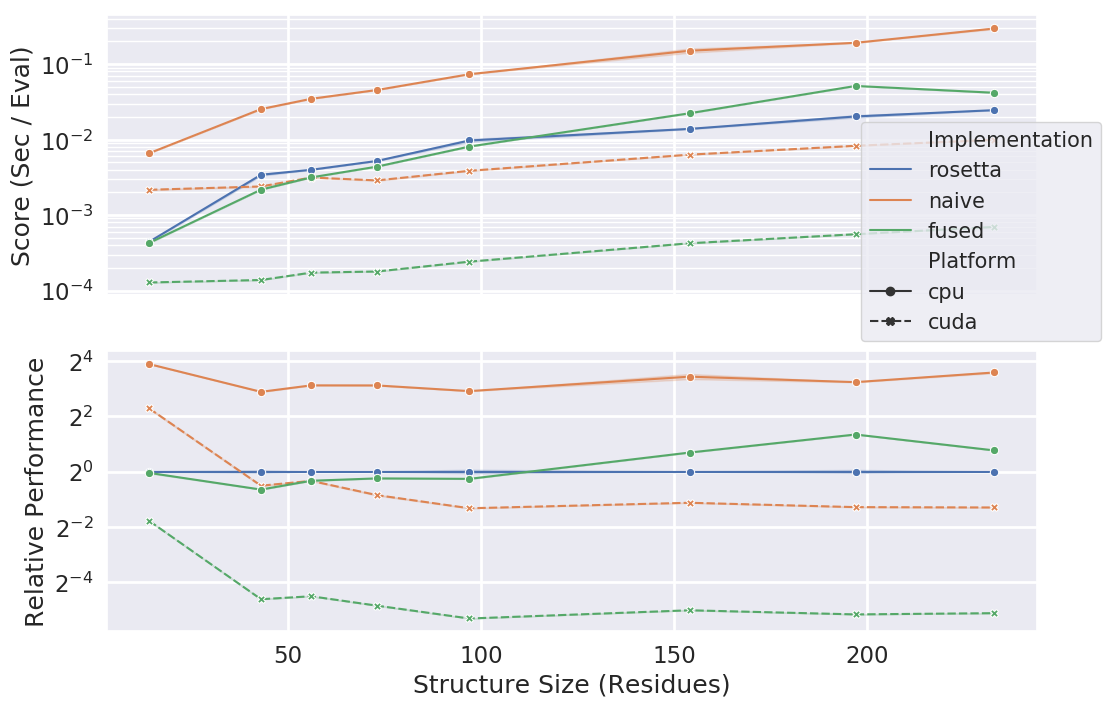

In [70]:
fdat = dat.query("nres < 256 and Implementation != 'numba'")

fdat["Structure Size (Residues)"] = fdat["nres"]
fdat["Score (Sec / Eval)"] = fdat["time"]
fdat["Relative Performance"] = fdat["rosetta_relative"]

f, (a1, a2) = pyplot.subplots(2, sharex=True, squeeze=True, figsize=(12, 8))

#pyplot.xscale("log", basex=10)

seaborn.set(font_scale=1.5)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("Structure Size (Residues)", "Score (Sec / Eval)", data=fdat, hue="Implementation", style="Platform", markers=True, legend=False)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("Structure Size (Residues)", "Relative Performance", data=fdat, hue="Implementation", style="Platform", markers=True, legend="brief")
pyplot.legend(bbox_to_anchor=(.8, 1.), fontsize="small")


In [36]:
display((
    dat.query("name=='score.rosetta_atr_rep'")
    .groupby("nres")[["time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

display((dat
    .groupby(("nres", "name"))[["rosetta_relative", "time"]]
    .describe()
    .reorder_levels((1, 0), axis=1)["mean"]
    .xs("score.tmol_lj_cuda_cpp", level=1)
    .eval("fold_acceleration = rosetta_relative ** -1")
))

,mean,max,std
,time,time,time
nres,,,
14,0.000406,0.002592,0.000080
43,0.003203,0.004565,0.000550
56,0.004055,0.006379,0.000377
73,0.004970,0.005124,0.000025
97,0.009315,0.013814,0.001622
154,0.014491,0.019785,0.001997
197,0.019450,0.019960,0.000176
233,0.023320,0.024436,0.000441


,rosetta_relative,time,fold_acceleration
nres,,,
14,0.316201,0.000128,3.162540
43,0.043603,0.000140,22.934453
56,0.043165,0.000175,23.166654
73,0.035935,0.000179,27.828073
97,0.026837,0.000250,37.261972
154,0.029683,0.000430,33.688996
197,0.029272,0.000569,34.162558
233,0.029677,0.000692,33.695689
298,0.031662,0.001127,31.583147
